# Load Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

## load data function

In [2]:
def load_data(file_pairs,src_dir='',dst_dir='.'):
    import os
    if not os.path.isdir(dst_dir):
        os.mkdir(dst_dir)
    for file_pair in file_pairs:
        src = os.path.abspath(os.path.expanduser(os.path.join(src_dir,file_pair[0])))
        dst = os.path.expanduser(os.path.join(dst_dir,file_pair[1]))
        if os.path.isfile(dst):
            os.remove(dst)
        if not os.path.islink(dst):
            os.symlink(src,dst)

def load_data_suffixes(file_pairs, src_dir='', dst_dir='.', suffixes=None):
    import os
    if not os.path.isdir(dst_dir):
        os.mkdir(dst_dir)
    if not suffixes:
        for file_pair in file_pairs:
            src = os.path.abspath(os.path.expanduser(os.path.join(src_dir, file_pair[0])))
            dst = os.path.expanduser(os.path.join(dst_dir, file_pair[1]))
            if os.path.isfile(dst):
                os.remove(dst)
            if not os.path.islink(dst):
                os.symlink(src, dst)
    else:
        for file_pair in file_pairs:
            for suffix_pair in suffixes:
                src = os.path.abspath(os.path.expanduser(
                    os.path.join(src_dir, file_pair[0] + suffix_pair[0])))
                dst = os.path.expanduser(
                    os.path.join(dst_dir, file_pair[1] + suffix_pair[1]))
                if os.path.isfile(dst):
                    os.remove(dst)
                if not os.path.islink(dst):
                    os.symlink(src, dst)

## box plot function

In [3]:
from seaborn.categorical import _BoxPlotter


class box_plotter(_BoxPlotter):
    def add_statistic_annotate(self, ax, x1, x2, y, h, value, text_type,
                               **kws):
        default_lw = mpl.rcParams["patch.linewidth"]
        lw = kws.get("linewidth", kws.get("lw", default_lw))
        width = x2 - x1
        x1, x2 = x1 + .1 * width, x2 - .1 * width
        ax.plot([x1, x1, x2, x2], [y + .5 * h, y + h, y + h, y + .5 * h],
                lw=1.5,
                c='k')
        if text_type == 'raw':
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    f'P = {value:.2e}',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.05:
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    'n.s.',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.01:
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    '*',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.001:
            ax.text((x1 + x2) * .5,
                    y_ + h * 1.5,
                    '**',
                    ha='center',
                    va='bottom',
                    color='k')
        else:
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    '***',
                    ha='center',
                    va='bottom',
                    color='k')

    def draw_statistic_annotate(self, ax, **kwargs):
        from operator import methodcaller
        from scipy import stats
        if kwargs.get('statistic_test') == 'mannwhitneyu':
            statistic_kwargs = {
                'use_continuity': kwargs.get('use_continuity', True),
                'alternative': kwargs.get('alternative', None)
            }
        elif kwargs.get('statistic_test') == 'wilcoxon':
            statistic_kwargs = {
                'zero_method': kwargs.get('zero_method', 'wilcox'),
                'correction': kwargs.get('correction', False),
                'alternative': kwargs.get('alternative', 'two-sided')
            }
        elif kwargs.get('statistic_test') == 'ttest_ind':
            statistic_kwargs = {
                'axis': kwargs.get('axis', 0),
                'equal_var': kwargs.get('equal_var', True),
                'nan_policy': kwargs.get('nan_policy', 'propagate')
            }
        elif kwargs.get('statistic_test') == 'ttest_rel':
            statistic_kwargs = {
                'axis': kwargs.get('axis', 0),
                'nan_policy': kwargs.get('nan_policy', 'propagate')
            }
        else:
            raise ValueError(
                'statistic_test must be either mannwhitneyu, wilcoxon, ttest_ind or ttest_rel.'
            )
        ylim = ax.get_ylim()
        h = .05 * (ylim[1] - ylim[0])
        if self.plot_hues is None:
            for i in range(len(self.plot_data) - 1):
                pvalue = methodcaller(kwargs.get('statistic_test'),
                                      self.plot_data[i], self.plot_data[i + 1],
                                      **statistic_kwargs)(stats).pvalue
                y = max(
                    mpl.cbook.boxplot_stats(self.plot_data[i])[0]['whishi'],
                    mpl.cbook.boxplot_stats(
                        self.plot_data[i + 1])[0]['whishi']) + .25 * h
                self.add_statistic_annotate(ax,
                                            i,
                                            i + 1,
                                            y,
                                            h,
                                            pvalue,
                                            text_type=kwargs.get(
                                                'text_type', 'raw'))
        else:
            for i in range(len(self.plot_data)):
                offsets = self.hue_offsets
                for j in range(len(self.hue_names) - 1):
                    pvalue = methodcaller(
                        kwargs.get('statistic_test'), self.plot_data[i][
                            self.plot_hues[i] == self.hue_names[j]],
                        self.plot_data[i][self.plot_hues[i] == self.hue_names[
                            j + 1]], **statistic_kwargs)(stats).pvalue
                    y = max(
                        mpl.cbook.boxplot_stats(
                            self.plot_data[i][self.plot_hues[i] ==
                                              self.hue_names[j]])[0]['whishi'],
                        mpl.cbook.boxplot_stats(self.plot_data[i][
                            self.plot_hues[i] == self.hue_names[j + 1]])[0]
                        ['whishi']) + .25 * h
                    self.add_statistic_annotate(ax,
                                                i + offsets[j],
                                                i + offsets[j + 1],
                                                y,
                                                h,
                                                pvalue,
                                                text_type=kwargs.get(
                                                    'text_type', 'raw'))
        ax.set_ylim(ylim[0], ylim[1] + 2.5 * h)


def boxplot(x=None,
            y=None,
            hue=None,
            data=None,
            order=None,
            hue_order=None,
            orient=None,
            color=None,
            palette=None,
            saturation=0.75,
            width=0.8,
            dodge=True,
            fliersize=5,
            linewidth=None,
            whis=1.5,
            ax=None,
            statistic_args=None,
            **kwargs):
    plotter = box_plotter(x, y, hue, data, order, hue_order, orient, color,
                          palette, saturation, width, dodge, fliersize,
                          linewidth)
    if ax is None:
        ax = plt.gca()
    kwargs.update(dict(whis=whis))
    plotter.draw_boxplot(ax, kwargs)
    plotter.annotate_axes(ax)
    if statistic_args:
        kwargs = statistic_args
        plotter.draw_statistic_annotate(ax, **kwargs)
    if plotter.orient == "h":
        ax.invert_yaxis()


## make_Ramp function

In [33]:
from colour import Color
from matplotlib.colors import LinearSegmentedColormap
def make_Ramp( ramp_colors ): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

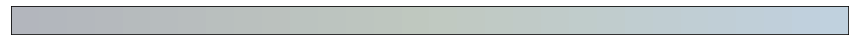

In [65]:
my_cmap_3 = make_Ramp(['#B3B6BD', '#C0C9C0', '#C0D1DF'])

## stack bar plot function

In [63]:
def stack_percentage_bar(results, horizontal=False, annotate='number'):
    import sys
    """\
    results : pandas.DataFrame
        results.index is the name of each sample.
        results.columns is the label of each category
    horizontal: bool
        If the figure should be horizontal.
    """
    # the following modules should been loaded before
    #import numpy as np
    #import matplotlib as mpl
    #mpl.rcParams['pdf.fonttype'] = 42
    #mpl.rcParams['ps.fonttype'] = 42
    #mpl.rcParams['font.sans-serif'] = 'Helvetica'
    #import matplotlib.pyplot as plt
    #import seaborn as sns
    percentage = results.div(results.sum(axis=1), axis=0) * 100
    percentage_cum = percentage.cumsum(axis=1)
    percentage_cum.loc[:, percentage_cum.shape[1] - 1] = 100.0
    category_colors = plt.get_cmap(my_cmap_3)(np.linspace(
        0.15, 0.85, results.shape[1]))
    if horizontal:
        fig, ax = plt.subplots(figsize=(6.4 * .75, 4.8))
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        for i, (category_name,
                color) in enumerate(zip(results.columns, category_colors)):
            widths = percentage.iloc[:, i]
            starts = percentage_cum.iloc[:, i] - widths
            ax.barh(results.index,
                    widths,
                    left=starts,
                    height=0.5,
                    label=category_name,
                    color=color)
            xcenters = starts + widths / 2
            r, g, b, _ = color
            text_color = 'white' if r * g * b < 0.33 else (
                'grey' if r * g * b < 0.66 else 'black')
            if annotate == 'number':
                text = [f'{x:d}' for x in results.iloc[:, i]]
            elif annotate == 'percentage':
                text = [f'{x/100:.2%}' for x in percentage.iloc[:, i]]
            else:
                sys.stdout.write(
                    f'Invalide annotate input: {annotate}. Use default parameters number.'
                )
                text = [f'{x:d}' for x in results.iloc[:, i]]
            for y, (x, c) in enumerate(zip(xcenters, text)):
                ax.text(x, y, c, ha='center', va='center', color=text_color)
        ax.set_xticks(np.arange(0, 120, 20))
        ax.set_xticklabels(np.arange(0, 120, 20))
        ax.set_xlabel('Percentage')
        ax.set_yticks(np.arange(percentage.shape[0]))
        ax.set_yticklabels(percentage.index)
        ax.set_ylabel('Sample')
        ax.legend(ncol=results.shape[1],
                  bbox_to_anchor=(0, 1),
                  loc='lower left',
                  fontsize='small')
    else:
        fig, ax = plt.subplots(figsize=(6.4 * .75, 4.8))
        ax.set_ylim(0, 100)
        for i, (category_name,
                color) in enumerate(zip(results.columns, category_colors)):
            hights = percentage.iloc[:, i]
            starts = percentage_cum.iloc[:, i] - hights
            ax.bar(results.index,
                   hights,
                   bottom=starts,
                   width=0.5,
                   label=category_name,
                   color=color)
            xcenters = starts + hights / 2
            r, g, b, _ = color
            text_color = 'white' if r * g * b < 0.33 else (
                'grey' if r * g * b < 0.66 else 'black')
            if annotate == 'number':
                text = [f'{x:d}' for x in results.iloc[:, i]]
            elif annotate == 'percentage':
                text = [f'{x/100:.2%}' for x in percentage.iloc[:, i]]
            else:
                sys.stdout.write(
                    f'Invalide annotate input: {annotate}. Use default parameters number.'
                )
                text = [f'{x:d}' for x in results.iloc[:, i]]
            for x, (c, y) in enumerate(zip(text, xcenters)):
                ax.text(x, y, c, ha='center', va='center', color=text_color)
        ax.set_xticks(np.arange(results.shape[0]))
        ax.set_xticklabels(percentage.index, rotation=45, ha='right')
        ax.set_xlabel('Sample')
        ax.set_yticks(np.arange(0, 120, 20))
        ax.set_yticklabels(np.arange(0, 120, 20))
        ax.set_ylabel('Percentage')
        ax.legend(bbox_to_anchor=(1, 0), loc='lower left')
    return fig, ax

# Load data

In [7]:
import os
os.chdir('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison')

In [8]:
%%bash
ls expression/*

expression/wt_elife_TPM.txt
expression/wt_embryo_TPM.txt


# Definition
- raw enrichment bin: coverage greater than mean + 3 * std
- merged cluster must in mixed bins

In [9]:
import os

with open(os.path.expanduser('/mnt/Storage/home/wangwen/source/bySpecies/danRer11_2/danRer11_2_main.chrom.sizes')) as fhd:
    chrom_size = {line.strip().split()[0]: int(line.strip().split()[1]) for line in fhd}

In [10]:
%%bash
ls ./dome_cluster/danRer11_2_1kb.bed

./dome_cluster/danRer11_2_1kb.bed


In [11]:
%%bash
# intersectBed -wo -a danRer11_2_1kb.bed -b Nanog_dome_filtered_peaks.narrowPeak > danRer11_2_1kb_ov_nanog_fitCR_dome.bed &
# intersectBed -c -a danRer11_2_1kb.bed -b  Nanog_dome_filtered_summits_annotation.txt > danRer11_2_1kb_ov_nanog_fitCR_dome_summits.bed &
# wait
ls ./dome_cluster/danRer11_2_1kb_ov_nanog_fitCR_dome.bed
ls ./dome_cluster/danRer11_2_1kb_ov_nanog_fitCR_dome_summits.bed


./dome_cluster/danRer11_2_1kb_ov_nanog_fitCR_dome.bed
./dome_cluster/danRer11_2_1kb_ov_nanog_fitCR_dome_summits.bed


In [13]:
from collections import defaultdict

def gen(window,step):
    from collections import deque
    window_size = window // step
    coverage = deque(maxlen = window_size)
    num = deque(maxlen = window_size)
    for chrom in genome_window['number']:
        for i in range(window_size):
            coverage.append(genome_window['coverage'][chrom].get(i,0))
            num.append(genome_window['number'][chrom].get(i,0))
        for i in range(window_size,len(genome_window['number'][chrom])):
            yield sum(coverage), sum(num)
            coverage.append(genome_window['coverage'][chrom].get(i,0))
            num.append(genome_window['number'][chrom].get(i,0))
        yield sum(coverage), sum(num)

def gen_cluster_bin(window,step,cutoff):
    from collections import deque
    window_size = window // step
    coverage = deque(maxlen = window_size)
    num = deque(maxlen = window_size)
    for chrom in genome_window['coverage']:
        i = -1
        maximum = max(genome_window['coverage'][chrom].keys())
        while i <= maximum:
            i += 1
            if i < window_size:
                coverage.append(genome_window['coverage'][chrom].get(i,0))
                num.append(genome_window['number'][chrom].get(i,0))
            else:
                if sum(coverage) > cutoff and sum(num) >= 3:
                    yield chrom, (i-window_size)*1000, (i-window_size)*1000+20000
                coverage.append(genome_window['coverage'][chrom].get(i,0))
                num.append(genome_window['number'][chrom].get(i,0))
        if sum(coverage) > cutoff and sum(num) >= 5:
            yield chrom, (i-window_size)*1000, (i-window_size)*1000+20000

#for factor in ['nanog','pou5f3','sox19b']:
for factor in ['nanog']:
    print(f'{factor}')
    #for method in ['chip','fitCR']:
    for method in ['fitCR']:
        print(f'\t{method}')
        genome_window = {'coverage': defaultdict(dict), 'number': defaultdict(dict)}
        with open(f'dome_cluster/danRer11_2_1kb_ov_{factor}_{method}_dome.bed') as fhd:
            for line in fhd:
                chrom, start, *_, coverage = line.strip().split()
                if chrom == 'chrM':
                    continue
                start, coverage = int(start), int(coverage)
                pos = start//1000
                if pos in genome_window['coverage'][chrom]:
                    genome_window['coverage'][chrom][pos] += coverage
                else:
                    genome_window['coverage'][chrom][pos] = coverage
        with open(f'dome_cluster/danRer11_2_1kb_ov_{factor}_{method}_dome_summits.bed') as fhd:
            for line in fhd:
                chrom, start, _, num = line.strip().split()
                if chrom == 'chrM':
                    continue
                start, num = int(start), int(num)
                genome_window['number'][chrom][start//1000] = num
        window = 20000
        summary_table = pd.DataFrame(gen(window,1000),columns=['coverage','num'])
        non_zero_table = summary_table.loc[[True if x > 0 else False for x in summary_table['coverage']],:]
        #print(f'mean: {non_zero_table["coverage"].mean()}')
        #print(f'std: {non_zero_table["coverage"].std()}')
        mean, std = non_zero_table['coverage'].mean(), non_zero_table['coverage'].std()
        print(mean, std)
        #print(sum(non_zero_table['coverage']>non_zero_table["coverage"].mean()+3*non_zero_table["coverage"].std()))
        cutoff = mean + 3 * std
        print(cutoff)
        #print(sum(non_zero_table['coverage']>cutoff))
        
#         with open(f'danRer11_2_1kb_ov_{factor}_{method}_dome_cluster.bed', 'w') as fhd:
#             for chrom, start, end in gen_cluster_bin(window,1000,cutoff):
#                 fhd.write(f'{chrom}\t{start}\t{end}\n')

nanog
	fitCR
325.033447331859 204.52958695435467
938.6222081949229


In [16]:
%%bash
# sort -k1,1 -k2,2n   danRer11_2_1kb_ov_nanog_fitCR_dome_cluster.bed | mergeBed -i - >   danRer11_2_nanog_fitCR_dome_cluster.bed
ls dome_cluster/danRer11_2_nanog_fitCR_dome_cluster.bed

dome_cluster/danRer11_2_nanog_fitCR_dome_cluster.bed


In [17]:
%%bash
# intersectBed  -u -a danRer11_2_nanog_fitCR_dome_cluster.bed -b Nanog_256_filtered_peaks.narrowPeak > danRer11_2_nanog_fitCR_dome_cluster_from_256.bed
wc -l dome_cluster/danRer11_2_nanog_fitCR_dome_cluster_from_256.bed


188 dome_cluster/danRer11_2_nanog_fitCR_dome_cluster_from_256.bed


# annotation

In [47]:
%%bash
# intersectBed -u -a Nanog_dome_cluster_summits_annotation.txt -b danRer11_2_nanog_fitCR_dome_cluster_from_256.bed > Nanog_dome_cluster_summits_annotation_from_256_cluster.txt
windowBed -w 5000 -u -a tss_inNanog_10kb/danRer11_2.ensGene.tss.bed -b dome_cluster/Nanog_dome_cluster_summits_annotation_from_256_cluster.txt > dome_cluster/danRer11_tss_in_cluster_from_256_5kb.bed
ls dome_cluster/Nanog_dome_cluster_summits_annotation_from_256_cluster.txt
ls dome_cluster/danRer11_tss_in_cluster_from_256_5kb.bed

dome_cluster/Nanog_dome_cluster_summits_annotation_from_256_cluster.txt
dome_cluster/danRer11_tss_in_cluster_from_256_5kb.bed


In [48]:
import os
danRer11_2_transcript_to_gene = {}

with open(os.path.expanduser('~wangwen/source/bySpecies/danRer11_2/danRer11_2.ensGene.genePredExt')) as fhd:
    for line in fhd:
        line = line.strip().split()
        danRer11_2_transcript_to_gene[line[0]]= line[11]

nanog_dome_in_cluster_genes = set()
with open('dome_cluster/danRer11_tss_in_cluster_from_256_5kb.bed') as fhd:
    for line in fhd:
        line = line.strip().split()
        try:
            nanog_dome_in_cluster_genes.add(danRer11_2_transcript_to_gene[line[3]].split('.')[0])
        except KeyError:
            pass

In [49]:
# https://biit.cs.ut.ee/gplink/l/kNeT42tpRL
with open('dome_cluster/nanog_dome_in_mixed_bin_cluster_genes.txt', 'w') as fhd:
    for g in nanog_dome_in_cluster_genes:
        fhd.write(g+'\n')


In [50]:
nanog_256_genes_in_5k, nanog_1k_genes_in_5k, nanog_dome_genes_in_5k = set(), set(), set()
with open('tss_inNanog_5kb/danRer11_tss_in_Nanog_256_5kb.bed') as fhd:
    for line in fhd:
        line = line.strip().split()
        try:
            nanog_256_genes_in_5k.add(danRer11_2_transcript_to_gene[line[3]].split('.')[0])
        except KeyError:
            pass

with open('tss_inNanog_5kb/danRer11_tss_in_Nanog_1k_5kb.bed') as fhd:
    for line in fhd:
        line = line.strip().split()
        try:
            nanog_1k_genes_in_5k.add(danRer11_2_transcript_to_gene[line[3]].split('.')[0])
        except KeyError:
            pass

with open('tss_inNanog_5kb/danRer11_tss_in_Nanog_dome_5kb.bed') as fhd:
    for line in fhd:
        line = line.strip().split()
        try:
            nanog_dome_genes_in_5k.add(danRer11_2_transcript_to_gene[line[3]].split('.')[0])
        except KeyError:
            pass
        
nanog_1k_new_genes_in_5k = nanog_1k_genes_in_5k - nanog_256_genes_in_5k
nanog_dome_new_genes_in_5k = nanog_dome_genes_in_5k - nanog_1k_genes_in_5k - nanog_256_genes_in_5k

In [51]:
nanog_256_genes_in_5kb_remove_cluster = nanog_256_genes_in_5k - nanog_dome_in_cluster_genes

In [52]:
nanog_256_genes_in_5kb_cluster = nanog_256_genes_in_5k & nanog_dome_in_cluster_genes

In [53]:
first_wave_genes_danRer11_2 = set()
with open('first_wave_genes/first_wave_genes_danRer11_2.txt') as fhd:
    for line in fhd:
        first_wave_genes_danRer11_2.add(line.strip())


In [54]:
earlyZGA_genes_danRer11_2 = set()
with open('earlyZGA_genes/earlyZGA_genes_danRer11_2.txt') as fhd:
    for line in fhd:
        earlyZGA_genes_danRer11_2.add(line.strip())


In [55]:
print(len(nanog_dome_in_cluster_genes))
print(len(first_wave_genes_danRer11_2 & nanog_dome_in_cluster_genes))
print(len(earlyZGA_genes_danRer11_2 & nanog_dome_in_cluster_genes))


217
36
46


# expression difference for early expressed genes

In [56]:
wt_TPM = pd.read_csv('expression/wt_elife_TPM.txt',sep='\t',index_col=0)
wt_TPM.index = [x.split('.')[0] for x in wt_TPM.index]
wt_TPM.head()

,1cell_1,1cell_2,1cell_3,1cell_4,1cell_5,2cell_2,2cell_3,2cell_4,2cell_5,128cell_1,...,4dpf_1,4dpf_2,4dpf_3,4dpf_4,4dpf_5,5dpf_1,5dpf_2,5dpf_3,5dpf_4,5dpf_5
ENSDARG00000000001,4.051978,3.052561,2.109864,2.795590,1.720883,5.180598,4.927223,5.027334,5.101963,15.595867,...,4.172472,3.276666,3.783347,2.894171,4.005893,3.327795,3.327846,4.583900,3.072847,3.741060
ENSDARG00000000002,0.273260,0.000000,0.000000,0.421684,0.000000,3.431821,2.770505,5.022453,2.730927,2.624475,...,14.846203,18.130838,18.304920,16.364960,14.593785,14.230783,14.521548,15.233061,13.637992,15.589039
ENSDARG00000000018,3.682254,3.903807,2.398350,2.654802,4.678908,6.978799,6.806111,6.629982,5.488103,31.126837,...,13.928451,9.418540,11.154407,11.441402,10.003105,11.769067,11.296991,11.140151,9.677064,11.711987
ENSDARG00000000019,111.574821,124.635323,133.629303,122.782967,132.583572,154.288986,153.131165,145.468079,130.540207,150.540787,...,82.607956,85.895851,86.441277,84.617149,87.631439,71.270645,76.949173,72.815437,77.683365,80.444313
ENSDARG00000000068,48.938435,54.039043,43.647762,44.146622,38.664574,47.618706,42.039539,59.580910,49.505104,99.220474,...,47.130775,47.723545,48.305008,42.552280,46.720215,35.423752,31.968729,34.127728,35.041656,36.358227


In [57]:
expression_stages = [
    '1cell', '2cell', '128cell', '1kcell', 'dome', '50epi', '6hpf', '8hpf',
    '10.33hpf', '16hpf_somites', '19hpf_somites', '24hpf', '30hpf', '36hpf',
    '2dpf', '3dpf', '4dpf', '5dpf'
]

stage_to_int = {stage: index for index, stage in enumerate(expression_stages)}


In [58]:
def gen(stage):
    for gene, row in wt_TPM.iterrows():

        if gene in nanog_256_genes_in_5kb_cluster:
            yield row.loc[[True if stage in sample else False for sample in wt_TPM.columns]].mean(), 'NBC target'
            continue

        elif gene in nanog_256_genes_in_5kb_remove_cluster:
            yield row.loc[[True if stage in sample else False for sample in wt_TPM.columns]].mean(), 'other target'

WT_TPM_dome = pd.DataFrame(gen('dome'),columns=['TPM','binding_status'])
WT_TPM_50epi = pd.DataFrame(gen('50epi'),columns=['TPM','binding_status'])

TPM_summary = pd.DataFrame(
    np.zeros(shape=(4, 3)),
    index=['dome NBC pre-MBT target', 'dome other pre-MBT target', '50epi NBC pre-MBT target', '50epi other pre-MBT target'],
    columns=['(50,)', '(5,50]', '[0,5]'],
)

binding_status_index_dome = {'NBC target': 0, 'other target': 1}
binding_status_index_50epi = {'NBC target': 2, 'other target': 3}


for index, row in WT_TPM_dome.iterrows():
    if row['TPM'] > 50:
        ci = 0
    elif row['TPM'] > 5:
        ci = 1
    else:
        ci = 2
    TPM_summary.iloc[binding_status_index_dome[row['binding_status']],ci] += 1
    
for index, row in WT_TPM_50epi.iterrows():
    if row['TPM'] > 50:
        ci = 0
    elif row['TPM'] > 5:
        ci = 1
    else:
        ci = 2
    TPM_summary.iloc[binding_status_index_50epi[row['binding_status']],ci] += 1
    
TPM_summary.head()

,"(50,)","(5,50]","[0,5]"
dome NBC pre-MBT target,42.0,37.0,46.0
dome other pre-MBT target,248.0,363.0,581.0
50epi NBC pre-MBT target,39.0,43.0,43.0
50epi other pre-MBT target,228.0,330.0,634.0


## stack bar plot -- Fig.S5H

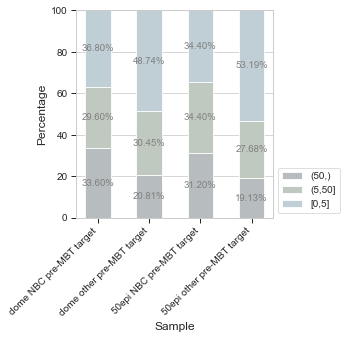

In [66]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):

    fig, ax = stack_percentage_bar(TPM_summary,
                                   horizontal=False,
                                   annotate='percentage')
    fig.tight_layout()
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig5H_stackbar_NBC_taget_with_high_expresseion.pdf',
                transparent=True)
    